# Đánh giá hiệu suất của các mô hình

In [9]:
# nhập tất cả các gói sẽ được sử dụng

# các gói cơ bản cho xử lý dữ liệu
import pandas as pd
import numpy as np

# gói cho các phép tính toán
import math

# các gói cho học máy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# các gói để giải thích kết quả huấn luyện
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# gói để đo thời gian chạy CPU
from time import process_time

# tắt các cảnh báo từ gói sklearn
# import warnings
# warnings.filterwarnings('ignore')

# thiết lập hạt giống ngẫu nhiên để đảm bảo kết quả có thể tái tạo
import random
random.seed(10)
np.random.seed(10)

In [11]:
features = pd.read_csv('Dataset/features_selected/CIC-IDS2017_RandomForestClassifier_20.csv').squeeze()
features = features[:11]

## Tải bộ dữ liệu

Trong notebook này, cả bộ dữ liệu huấn luyện và bộ dữ liệu kiểm tra đều được sử dụng.

In [15]:
columns = features.tolist() +  ['Label']

ids2017 = pd.read_csv('Dataset/dataset_cleaned/CIC-IDS2017.csv', usecols=columns)
ids2017.shape

(649762, 12)

In [17]:
# Tải bộ dữ liệu ids2018 để đánh giá mô hình.
ids2018 = pd.read_csv('Dataset/dataset_cleaned/CSE-CIC-IDS2018.csv', usecols=columns)
ids2018.shape

(515582, 12)

## Xử lý bổ sung

In [20]:
ids2017 = ids2017.sample(frac=0.1).reset_index(drop=True)
ids2018 = ids2018.sample(frac=0.1).reset_index(drop=True)

### Tách các đặc trưng và nhãn

Tách các đặc trưng và biến đầu ra. Bộ dữ liệu CIC-IDS2017 sẽ được chia thêm thành bộ dữ liệu huấn luyện và kiểm tra để so sánh độ chính xác với bộ dữ liệu CSE-CIC-IDS2018.

In [23]:
ids2017_X = ids2017.drop('Label', axis=1).copy()
ids2017_y = ids2017['Label'].copy()

ids2017_train_X, ids2017_test_X, ids2017_train_y, ids2017_test_y = train_test_split(ids2017_X, ids2017_y, test_size=0.3)

In [25]:
ids2018_X = ids2018.drop('Label', axis=1).copy()
ids2018_y = ids2018['Label'].copy()

### Chuẩn hóa dữ liệu

In [28]:
scalar = StandardScaler()
# only fit the training data
ids2017_train_X_scaled = scalar.fit(ids2017_train_X)

ids2017_train_X_scaled = scalar.transform(ids2017_train_X)
ids2017_test_X_scaled = scalar.transform(ids2017_test_X)
ids2018_X_scaled = scalar.transform(ids2018_X)

## Xây dựng các mô hình tối ưu

In [31]:
models = {
    'Decision Tree': tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=1.4401469385343852e-05),
    'Random Forest': RandomForestClassifier(max_depth=20, min_samples_leaf=0.00001, min_samples_split=0.00001, n_estimators=350, n_jobs=-1,criterion='gini'),
    'Support Vector Machine': SVC(C=100, gamma=1, kernel='rbf'),
    'Naive Bayes': GaussianNB(var_smoothing=1.0),
    'Artificial Neural Network': MLPClassifier(hidden_layer_sizes=(50,), activation='tanh', alpha=0.0001, solver='adam', max_iter=1000),
    'Deep Neural Network': MLPClassifier(hidden_layer_sizes=(15, 15, 15), activation='tanh', alpha=1e-05, solver='adam', max_iter=1000)
}

------------------------- Decision Tree -------------------------
              precision    recall  f1-score   support

      benign     0.9985    0.9933    0.9959      9824
   malicious     0.9932    0.9984    0.9958      9669

    accuracy                         0.9958     19493
   macro avg     0.9958    0.9959    0.9958     19493
weighted avg     0.9959    0.9958    0.9958     19493

------------------------- Random Forest -------------------------
              precision    recall  f1-score   support

      benign     0.9989    0.9945    0.9967      9824
   malicious     0.9944    0.9989    0.9966      9669

    accuracy                         0.9967     19493
   macro avg     0.9967    0.9967    0.9967     19493
weighted avg     0.9967    0.9967    0.9967     19493

------------------------- Support Vector Machine -------------------------
              precision    recall  f1-score   support

      benign     0.9923    0.9278    0.9590      9824
   malicious     0.9312    0.9

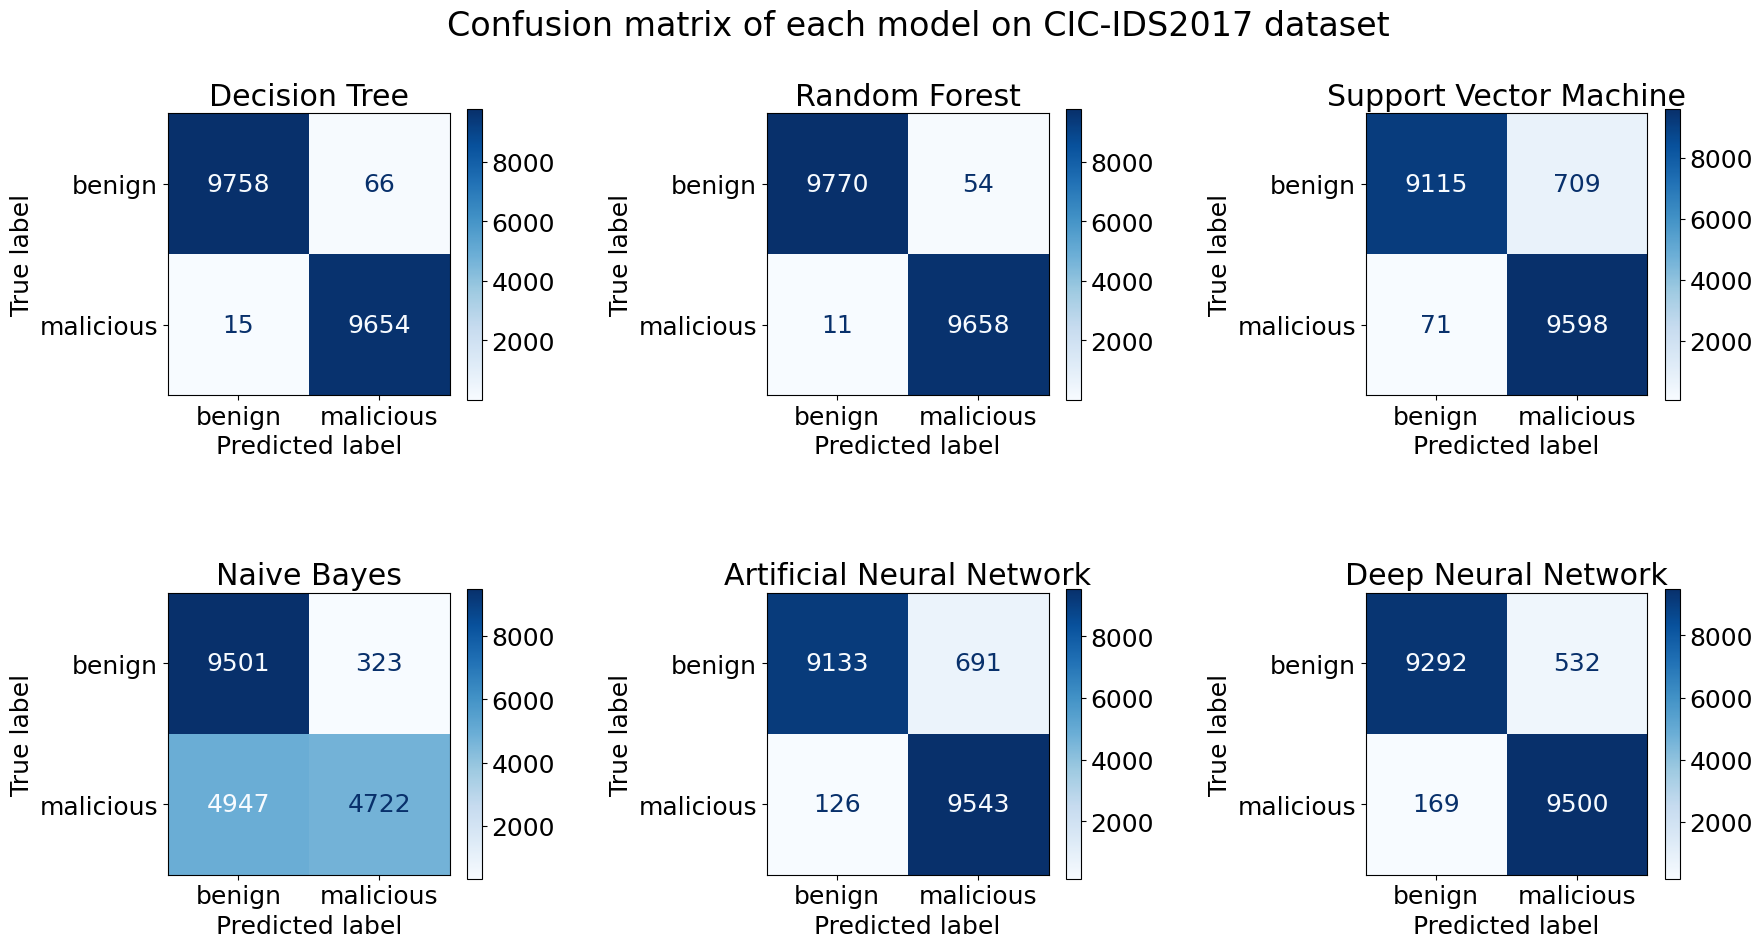

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

# Đóng tất cả các biểu đồ trước đó để tránh trùng lặp
plt.close('all')

trained_models = {}
training_time = {}
accuracy_train_dataset = {}
f_score_train_dataset = {}

plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (model, clf) in enumerate(models.items()):

    training_start_time = process_time()
    clf.fit(ids2017_train_X_scaled, ids2017_train_y)

    # save the training time
    training_time[model] = process_time() - training_start_time

    # save the trained model
    trained_models[model] = clf

    prediction = clf.predict(ids2017_test_X_scaled)
    model_report = metrics.classification_report(ids2017_test_y, prediction, digits=4, output_dict=True)

    # save the accuracy and the f1-score of each model
    accuracy_train_dataset[model] = model_report['accuracy']
    f_score_train_dataset[model] = model_report['weighted avg']['f1-score']

    print(f"{'-'*25} {model} {'-'*25}")
    print(metrics.classification_report(ids2017_test_y, prediction, digits=4))

    # Plot confusion matrix using ConfusionMatrixDisplay
    cm = confusion_matrix(ids2017_test_y, prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malicious'])
    disp.plot(ax=axes[math.floor(i/3)][i%3], cmap=plt.cm.Blues)
    axes[math.floor(i/3)][i%3].set_title(model)

fig.subplots_adjust(hspace=0.65, wspace=0.7)
fig.suptitle('Confusion matrix of each model on CIC-IDS2017 dataset', fontsize=24)

# Hiển thị hình duy nhất
plt.show()

# Đánh giá mô hình bằng cách sử dụng bộ dữ liệu CSE-CIC-2018

------------------------- Decision Tree -------------------------
              precision    recall  f1-score   support

      benign     0.5546    0.9660    0.7046     25835
   malicious     0.8660    0.2208    0.3518     25723

    accuracy                         0.5942     51558
   macro avg     0.7103    0.5934    0.5282     51558
weighted avg     0.7099    0.5942    0.5286     51558

------------------------- Random Forest -------------------------
              precision    recall  f1-score   support

      benign     0.5549    0.9668    0.7051     25835
   malicious     0.8688    0.2212    0.3526     25723

    accuracy                         0.5948     51558
   macro avg     0.7119    0.5940    0.5288     51558
weighted avg     0.7115    0.5948    0.5292     51558

------------------------- Support Vector Machine -------------------------
              precision    recall  f1-score   support

      benign     0.6977    0.9049    0.7879     25835
   malicious     0.8639    0.6

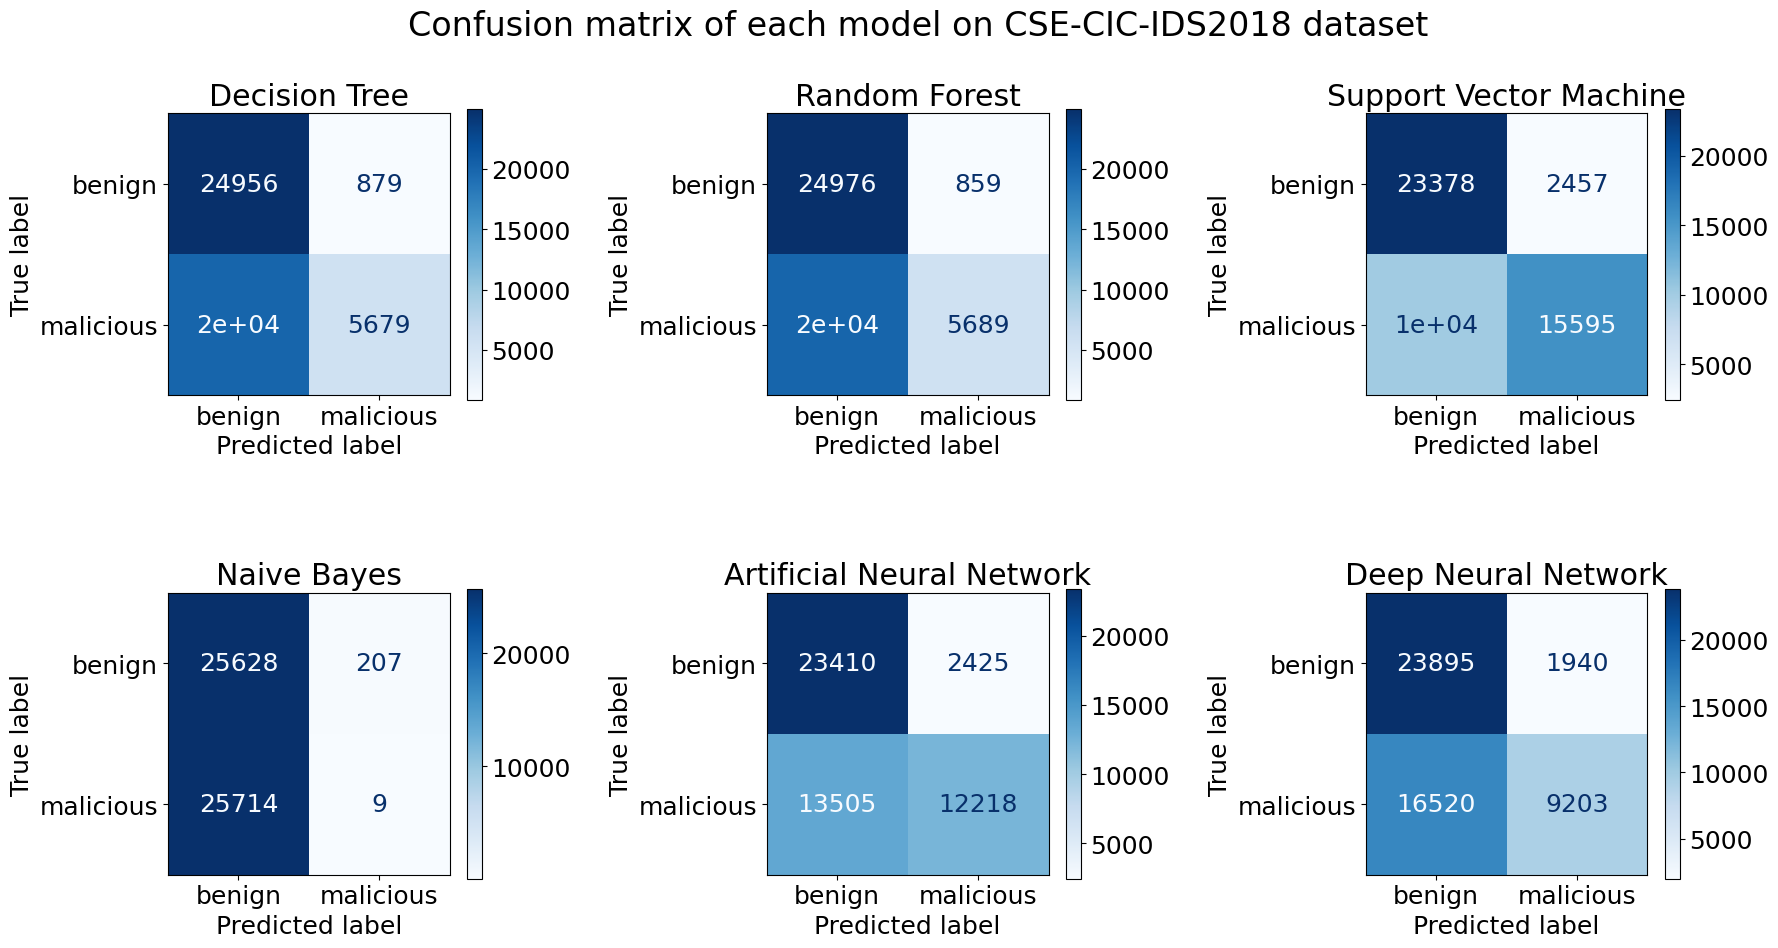

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from time import process_time
import math

# Đóng tất cả các biểu đồ trước đó để tránh trùng lặp
plt.close('all')

prediction_time = {}
accuracy_testing_dataset = {}
f_score_testing_dataset = {}

# Tạo bố cục 2 hàng 3 cột để chứa 6 mô hình
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (model, clf) in enumerate(trained_models.items()):
    prediction_start_time = process_time()
    prediction = clf.predict(ids2018_X_scaled)

    # save the time consumption for prediction
    prediction_time[model] = process_time() - prediction_start_time

    model_report = classification_report(ids2018_y, prediction, digits=4, output_dict=True)

    # save the accuracy and the f1-score of each model
    accuracy_testing_dataset[model] = model_report['accuracy']
    f_score_testing_dataset[model] = model_report['weighted avg']['f1-score']

    print(f"{'-'*25} {model} {'-'*25}")
    print(classification_report(ids2018_y, prediction, digits=4))

    # Plot confusion matrix using ConfusionMatrixDisplay
    cm = confusion_matrix(ids2018_y, prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malicious'])
    disp.plot(ax=axes[math.floor(i/3)][i%3], cmap=plt.cm.Blues)
    axes[math.floor(i/3)][i%3].set_title(model)

fig.subplots_adjust(hspace=0.65, wspace=0.7)
fig.suptitle('Confusion matrix of each model on CSE-CIC-IDS2018 dataset', fontsize=24)

# Hiển thị hình duy nhất
plt.show()

## So sánh

Trong phần này, việc so sánh giữa các mô hình sẽ được thực hiện dựa trên độ chính xác (accuracy) và điểm F1 (f1-score). Ngoài ra, thời gian mà mỗi mô hình tiêu tốn để huấn luyện và dự đoán dữ liệu kiểm tra cũng sẽ được so sánh.

In [55]:
# Định nghĩa hàm tạo nhãn trên đỉnh các thanh.
def label_top(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, height, f"{height:.2f}", ha='center', va='bottom')

### Độ chính xác - Accuracy

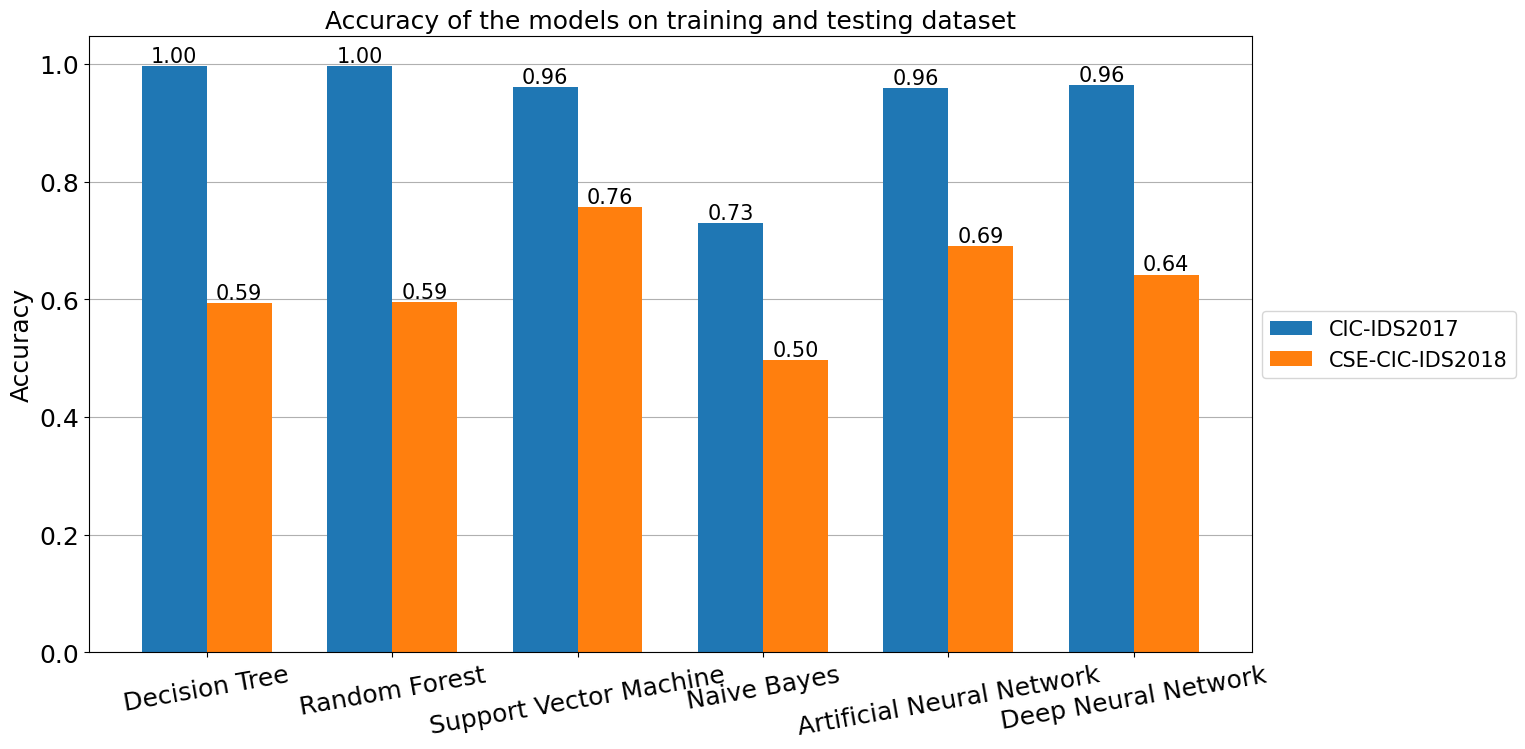

In [58]:
fig, ax = plt.subplots(figsize= (15, 8))
plt.rcParams.update({'font.size': 15})

x = np.arange(len(accuracy_train_dataset.keys())) # label location
width = 0.35 # width of the bar

bar1 = ax.bar(x - width/2, accuracy_train_dataset.values(), width, label='CIC-IDS2017')
bar2 = ax.bar(x + width/2, accuracy_testing_dataset.values(), width, label='CSE-CIC-IDS2018')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of the models on training and testing dataset')
ax.set_xticks(x)
ax.set_xticklabels(accuracy_train_dataset.keys())
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center') # rotate the label
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

# put a legend to the right of the axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

label_top(bar1)
label_top(bar2)

plt.show()

### F1-score

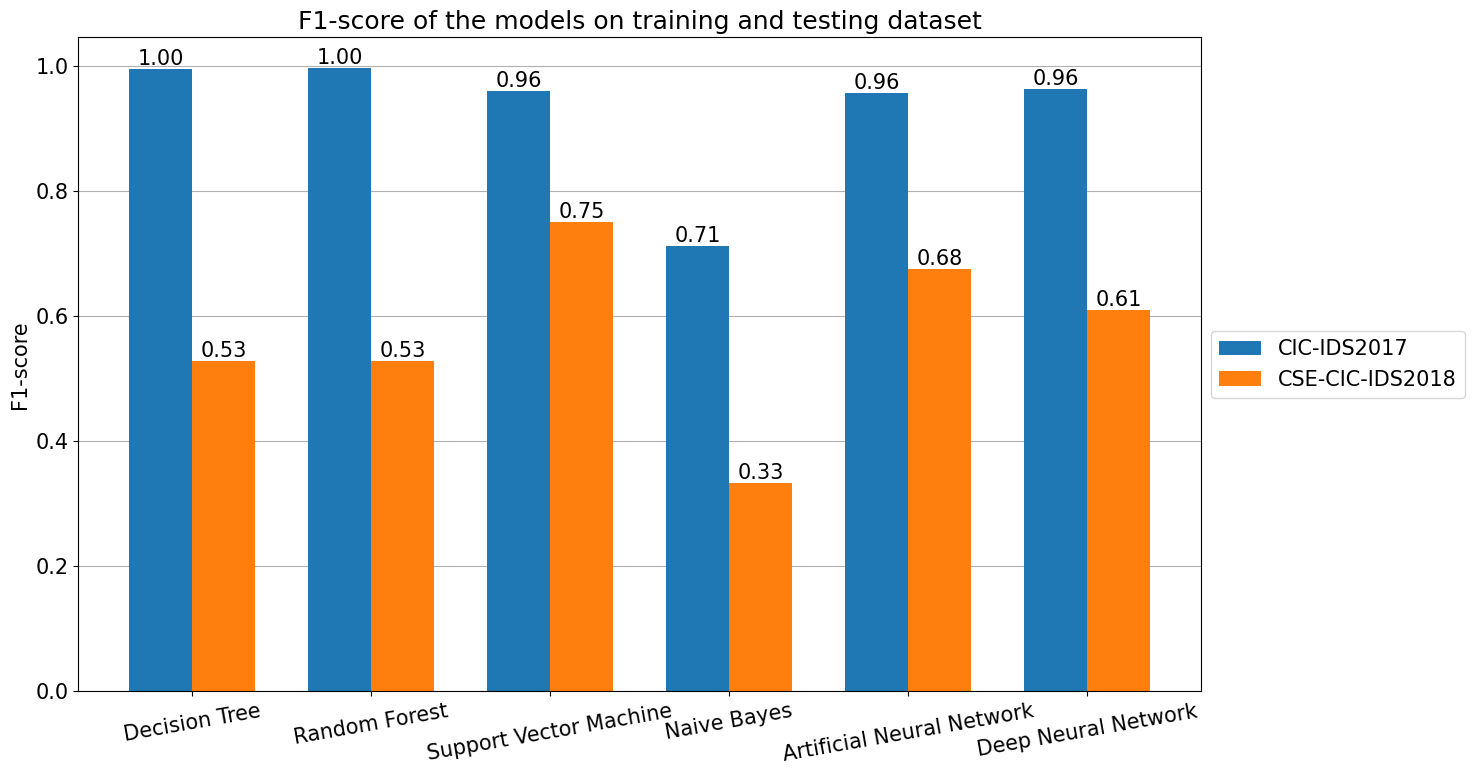

In [61]:
fig, ax = plt.subplots(figsize= (15, 8))
plt.rcParams.update({'font.size': 15})

x = np.arange(len(f_score_train_dataset.keys())) # label location
width = 0.35 # width of the bar

bar1 = ax.bar(x - width/2, f_score_train_dataset.values(), width, label='CIC-IDS2017')
bar2 = ax.bar(x + width/2, f_score_testing_dataset.values(), width, label='CSE-CIC-IDS2018')

ax.set_ylabel('F1-score')
ax.set_title('F1-score of the models on training and testing dataset')
ax.set_xticks(x)
ax.set_xticklabels(f_score_train_dataset.keys())
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center') # rotate the label
ax.legend()
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

# put a legend to the right of the axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

label_top(bar1)
label_top(bar2)

fig.tight_layout()

plt.show()

### Thời gian tiêu tốn cho việc huấn luyện (Time consumption for training)

Thời gian huấn luyện mô hình là thời gian mà mô hình cần để học từ dữ liệu huấn luyện. Điều này bao gồm quá trình tính toán và điều chỉnh các tham số trong mô hình sao cho mô hình có thể dự đoán chính xác nhất.

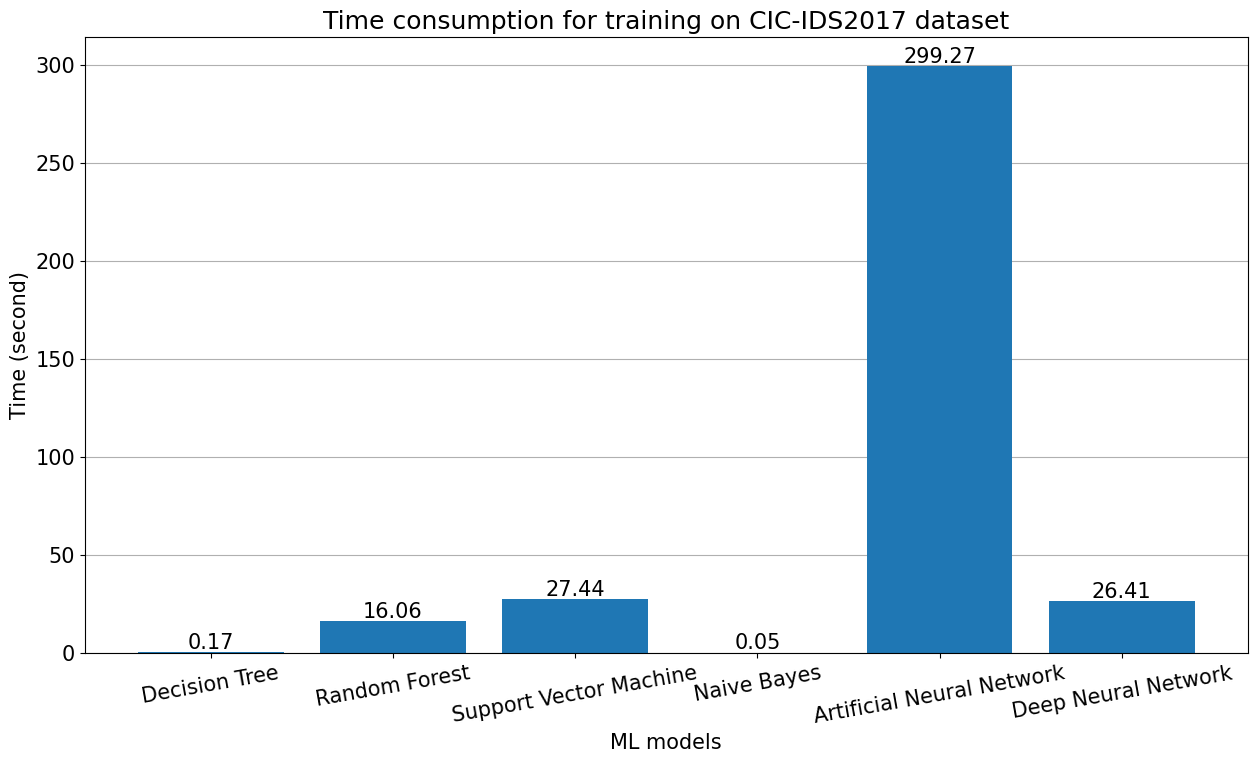

In [64]:
fig, ax = plt.subplots(figsize= (15, 8))

bar = ax.bar(training_time.keys(), training_time.values())
ax.set_xlabel("ML models")
ax.set_ylabel("Time (second)")
ax.set_title("Time consumption for training on CIC-IDS2017 dataset")
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center') # rotate the label
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

label_top(bar)

plt.show()

### Thời gian tiêu tốn cho dự đoán (Time consumption for prediction)

Thời gian dự đoán là thời gian mà mô hình cần để đưa ra dự đoán cho một bộ dữ liệu kiểm tra (testing dataset) sau khi đã được huấn luyện. Thời gian này có thể phụ thuộc vào nhiều yếu tố như kích thước của tập kiểm tra, độ phức tạp của mô hình, và phần cứng mà mô hình đang chạy.

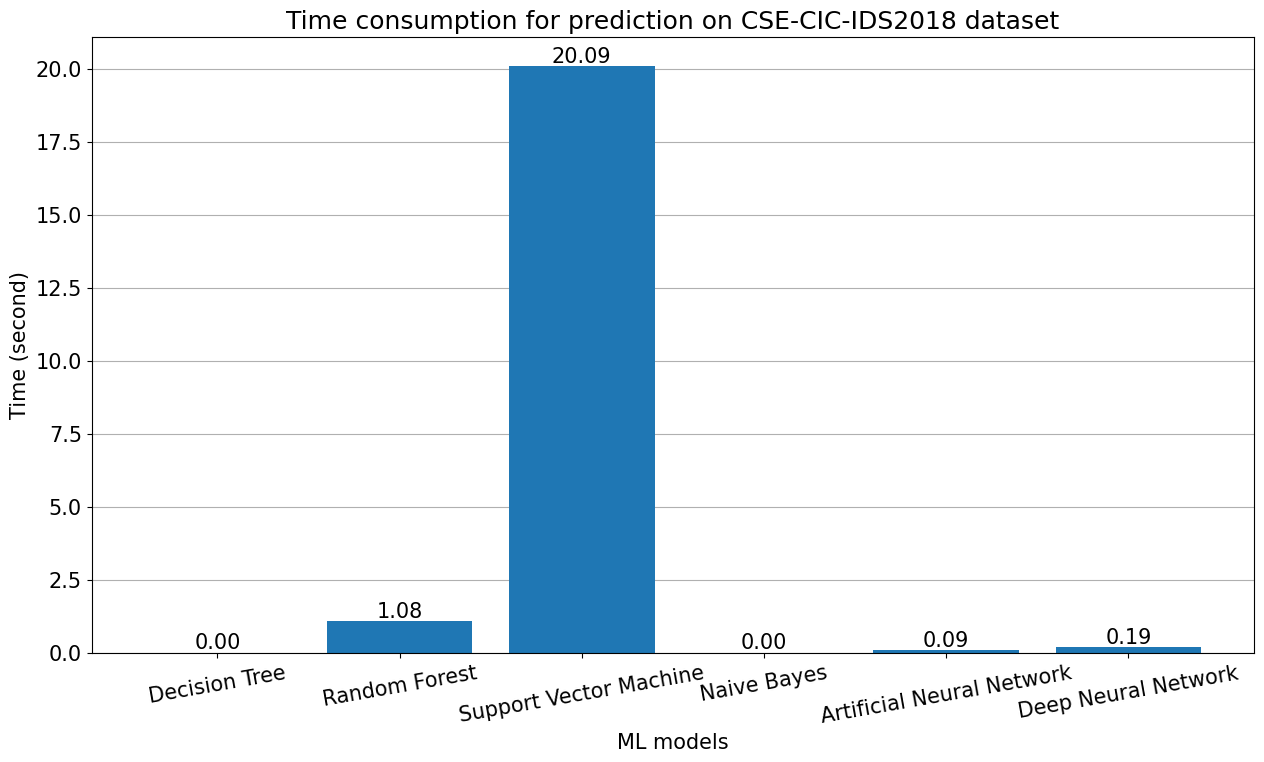

In [67]:
fig, ax = plt.subplots(figsize= (15, 8))

bar = ax.bar(prediction_time.keys(), prediction_time.values())
ax.set_xlabel("ML models")
ax.set_ylabel("Time (second)")
ax.set_title("Time consumption for prediction on CSE-CIC-IDS2018 dataset")
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center')
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

label_top(bar)

plt.show()